In [1]:
!pip install tensorflow
!pip install tensorflow_datasets
!pip install transformers
!pip install tf-keras
!pip install shap

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shap
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(123)
np.random.seed(123)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

2025-06-26 23:43:10.902774: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 23:43:10.907925: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 23:43:10.920612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750981390.941641    3061 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750981390.947770    3061 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750981390.964460    3061 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

TensorFlow version: 2.19.0
GPU Available: []


2025-06-26 23:43:14.731842: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# Configuration - Much smaller and more manageable
IMG_SIZE = (64, 64)  # Smaller image size
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 2  # Binary classification: airplanes vs dogs
LEARNING_RATE = 1e-3
SUBSET_SIZE = 5000  # Use only 5000 images per class

# Define class names
CLASS_NAMES = ['airplane', 'dog']

print("\n1. PREPARING DATA")
print("-" * 30)

def create_airplanes_vs_dogs_subset():
    """Create a airplanes vs dogs binary classification dataset using CIFAR-10"""
    
    print("Loading CIFAR-10...")
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    
    # CIFAR-10 classes: 0=airplane, 1=automobile, 2=bird, 3=cat, 4=deer, 
    #                   5=dog, 6=frog, 7=horse, 8=ship, 9=truck
    
    # Extract airplanes (class 0) and dogs (class 5)
    airplane_indices_train = np.where(y_train.flatten() == 0)[0]
    dog_indices_train = np.where(y_train.flatten() == 5)[0]
    
    airplane_indices_test = np.where(y_test.flatten() == 0)[0]
    dog_indices_test = np.where(y_test.flatten() == 5)[0]
    
    # Limit the subset size to avoid memory issues
    airplane_indices_train = airplane_indices_train[:min(SUBSET_SIZE, len(airplane_indices_train))]
    dog_indices_train = dog_indices_train[:min(SUBSET_SIZE, len(dog_indices_train))]
    
    airplane_indices_test = airplane_indices_test[:min(SUBSET_SIZE//4, len(airplane_indices_test))]
    dog_indices_test = dog_indices_test[:min(SUBSET_SIZE//4, len(dog_indices_test))]
    
    # Extract the images and labels
    x_train_airplanes = x_train[airplane_indices_train]
    x_train_dogs = x_train[dog_indices_train]
    x_test_airplanes = x_test[airplane_indices_test]
    x_test_dogs = x_test[dog_indices_test]
    
    # Combine airplanes and dogs
    x_train_subset = np.concatenate([x_train_airplanes, x_train_dogs], axis=0)
    x_test_subset = np.concatenate([x_test_airplanes, x_test_dogs], axis=0)
    
    # Create binary labels (0 for airplanes, 1 for dogs)
    y_train_subset = np.concatenate([
        np.zeros(len(x_train_airplanes)), 
        np.ones(len(x_train_dogs))
    ])
    y_test_subset = np.concatenate([
        np.zeros(len(x_test_airplanes)), 
        np.ones(len(x_test_dogs))
    ])
    
    # Shuffle the data
    train_indices = np.random.permutation(len(x_train_subset))
    test_indices = np.random.permutation(len(x_test_subset))
    
    x_train_subset = x_train_subset[train_indices]
    y_train_subset = y_train_subset[train_indices]
    x_test_subset = x_test_subset[test_indices]
    y_test_subset = y_test_subset[test_indices]
    
    # Convert to float32 and normalize
    x_train_subset = x_train_subset.astype('float32') / 255.0
    x_test_subset = x_test_subset.astype('float32') / 255.0
    
    # Resize to our target size (64x64 instead of 224x224)
    print(f"Resizing images from 32x32 to {IMG_SIZE}...")
    x_train_subset = tf.image.resize(x_train_subset, IMG_SIZE).numpy()
    x_test_subset = tf.image.resize(x_test_subset, IMG_SIZE).numpy()
    
    print(f"Training data shape: {x_train_subset.shape}")
    print(f"Training labels shape: {y_train_subset.shape}")
    print(f"Test data shape: {x_test_subset.shape}")
    print(f"Test labels shape: {y_test_subset.shape}")
    print(f"Airplanes in training: {np.sum(y_train_subset == 0)}")
    print(f"Dogs in training: {np.sum(y_train_subset == 1)}")
    
    return (x_train_subset, y_train_subset), (x_test_subset, y_test_subset)

# Load data
(x_train, y_train), (x_test, y_test) = create_airplanes_vs_dogs_subset()

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Data augmentation for training (lighter augmentation)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def augment_data(image, label):
    image = data_augmentation(image, training=True)
    return image, label

# Prepare datasets
train_dataset = train_dataset.map(augment_data).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Training batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_dataset).numpy()}")


1. PREPARING DATA
------------------------------
Loading CIFAR-10...
Resizing images from 32x32 to (64, 64)...
Training data shape: (10000, 64, 64, 3)
Training labels shape: (10000,)
Test data shape: (2000, 64, 64, 3)
Test labels shape: (2000,)
Airplanes in training: 5000
Dogs in training: 5000
Training batches: 313
Test batches: 63


In [4]:
# 2. Model Architecture - Smaller and more efficient
print("\n2. BUILDING MODEL")
print("-" * 30)

def create_simple_cnn():
    """Create a simple CNN for binary classification"""
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=(*IMG_SIZE, 3)),
        
        # First conv block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        
        # Second conv block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        
        # Third conv block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        
        # Flatten and dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

# Create model
model = create_simple_cnn()

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("Model Summary:")
model.summary()


2. BUILDING MODEL
------------------------------
Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,225 (2.61 MB)

 Trainable params: 683,777 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
# 3. Training
print("\n3. TRAINING MODEL")
print("-" * 30)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7
    )
]

# Train model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks,
    verbose=1
)


3. TRAINING MODEL
------------------------------
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 87ms/step - accuracy: 0.8394 - loss: 0.4964 - val_accuracy: 0.8505 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.9105 - loss: 0.2455 - val_accuracy: 0.8230 - val_loss: 0.3976 - learning_rate: 0.0010
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9194 - loss: 0.2081 - val_accuracy: 0.9400 - val_loss: 0.1506 - learning_rate: 0.0010
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9292 - loss: 0.1898 - val_accuracy: 0.9430 - val_loss: 0.1614 - learning_rate: 0.0010
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9354 - loss: 0.1699 - val_accuracy: 0.9365 - val_loss: 0.1521 - learning_rate: 0.0010
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.9390 - loss: 0.1507 - val_accuracy: 0.9540 - val_loss: 0.1182 - learning_rate: 5.0000e-04
Epoch 7/10
313/313 ━━━


4. EVALUATION
------------------------------
Test Accuracy: 0.9600
Test Loss: 0.1119


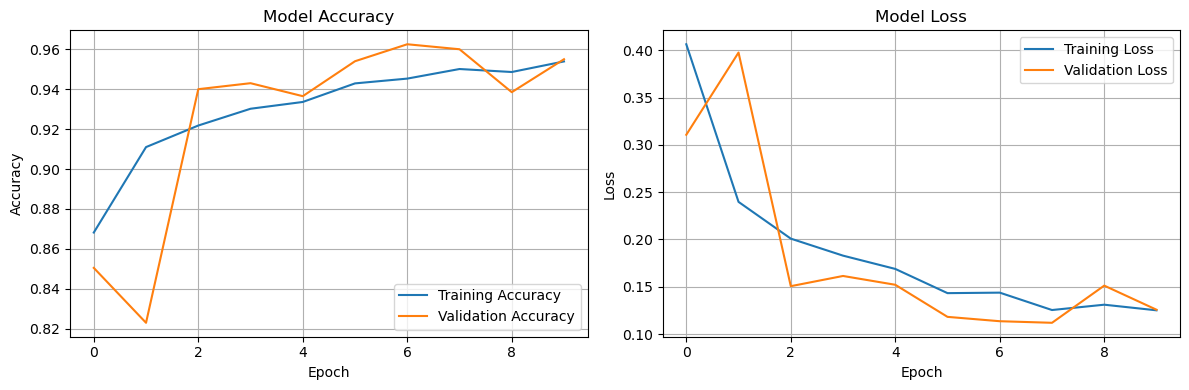

In [6]:
# 4. Evaluation and Visualization
print("\n4. EVALUATION")
print("-" * 30)

# Evaluate model
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


5. SAMPLE PREDICTIONS
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


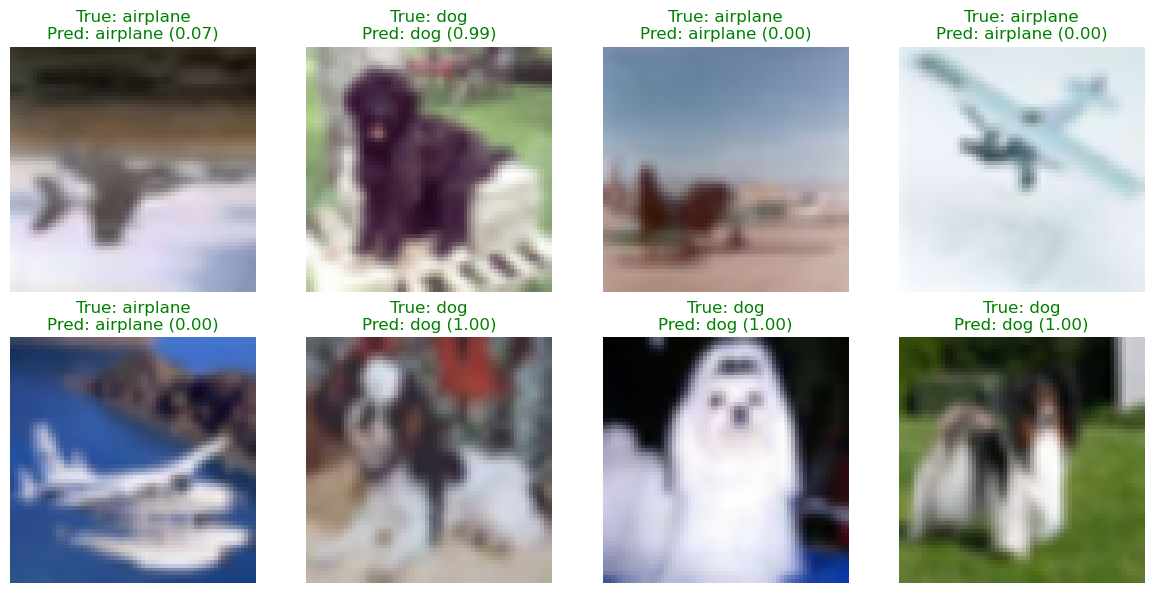


TRAINING COMPLETE!


In [7]:
# 5. Sample Predictions
print("\n5. SAMPLE PREDICTIONS")
print("-" * 30)

def show_predictions(model, dataset, num_samples=8):
    """Show sample predictions"""
    # Get a batch of test data
    for images, labels in dataset.take(1):
        predictions = model.predict(images[:num_samples])
        
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        axes = axes.ravel()
        
        for i in range(num_samples):
            # Display image
            axes[i].imshow(images[i])
            
            # Get prediction
            pred_prob = predictions[i][0]
            pred_class = int(pred_prob > 0.5)
            true_class = int(labels[i])
            
            # Set title with prediction info
            color = 'green' if pred_class == true_class else 'red'
            axes[i].set_title(
                f'True: {CLASS_NAMES[true_class]}\n'
                f'Pred: {CLASS_NAMES[pred_class]} ({pred_prob:.2f})',
                color=color
            )
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        break

show_predictions(model, test_dataset)

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)

In [8]:
print("Setting up SHAP for Global Explanations")
print("=" * 50)

class GlobalSHAPExplainer:
    def __init__(self, model, background_data, class_names):
        """
        Initialize Global SHAP Explainer
        
        Args:
            model: Trained TensorFlow/Keras model
            background_data: Background dataset for SHAP (subset of training data)
            class_names: List of class names
        """
        self.model = model
        self.class_names = class_names
        self.background_data = background_data
        
        # Create SHAP explainer
        print("Creating SHAP DeepExplainer...")
        self.explainer = shap.GradientExplainer(model, background_data)
        
    def explain_global_patterns(self, test_data, test_labels, n_samples=200):
        """
        Generate comprehensive global explanations
        
        Args:
            test_data: Test images
            test_labels: Test labels
            n_samples: Number of samples to analyze for global patterns
        """
        print(f"\nGenerating SHAP values for {n_samples} samples...")
        
        # Select random subset for global analysis
        indices = np.random.choice(len(test_data), min(n_samples, len(test_data)), replace=False)
        sample_data = test_data[indices]
        sample_labels = test_labels[indices]
        
        # Get SHAP values
        shap_values = self.explainer.shap_values(sample_data)
        
        # For binary classification, shap_values might be a list with one element
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
        
        self.shap_values = shap_values
        self.sample_data = sample_data
        self.sample_labels = sample_labels
        
        return shap_values, sample_data, sample_labels
    
    def plot_global_feature_importance(self):
        """Plot global feature importance across all samples"""
        print("\n1. Global Feature Importance Analysis")
        print("-" * 40)
        
        # Debug: Print shapes first
        print(f"SHAP values shape: {self.shap_values.shape}")
        print(f"Sample data shape: {self.sample_data.shape}")
        
        # Handle different possible shapes of SHAP values
        if len(self.shap_values.shape) == 4:
            # Expected case: (n_samples, height, width, channels)
            mean_shap = np.mean(np.abs(self.shap_values), axis=0)
            importance_map = np.mean(mean_shap, axis=2)  # Average across color channels
        elif len(self.shap_values.shape) == 2:
            # Case: already flattened - reshape back to image dimensions
            h, w, c = self.sample_data.shape[1], self.sample_data.shape[2], self.sample_data.shape[3]
            shap_reshaped = self.shap_values.reshape(-1, h, w, c)
            mean_shap = np.mean(np.abs(shap_reshaped), axis=0)
            importance_map = np.mean(mean_shap, axis=2)
        else:
            print(f"Unexpected SHAP shape: {self.shap_values.shape}")
            # Try to reshape and continue
            h, w, c = self.sample_data.shape[1], self.sample_data.shape[2], self.sample_data.shape[3]
            shap_reshaped = self.shap_values.reshape(-1, h, w, c)
            mean_shap = np.mean(np.abs(shap_reshaped), axis=0)
            importance_map = np.mean(mean_shap, axis=2)
        
        # Create heatmap of important regions
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image average
        avg_image = np.mean(self.sample_data, axis=0)
        axes[0].imshow(avg_image)
        axes[0].set_title('Average Input Image')
        axes[0].axis('off')
        
        # SHAP importance heatmap
        im1 = axes[1].imshow(importance_map, cmap='hot')
        axes[1].set_title('Global Feature Importance\n(Lighter = More Important)')
        axes[1].axis('off')
        plt.colorbar(im1, ax=axes[1])
        
        # Overlay importance on average image
        axes[2].imshow(avg_image)
        axes[2].imshow(importance_map, alpha=0.6, cmap='hot')
        axes[2].set_title('Importance Overlay')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Statistics about important regions
        flat_importance = importance_map.flatten()
        print(f"Most important pixel value: {np.max(flat_importance):.4f}")
        print(f"Average importance: {np.mean(flat_importance):.4f}")
        print(f"Std importance: {np.std(flat_importance):.4f}")
    
    def plot_class_specific_patterns(self):
        """Analyze patterns specific to each class"""
        print("\n2. Class-Specific Pattern Analysis")
        print("-" * 40)
        
        fig, axes = plt.subplots(2, len(self.class_names), figsize=(12, 8))
        
        for class_idx, class_name in enumerate(self.class_names):
            # Get samples for this class
            class_mask = self.sample_labels == class_idx
            if not np.any(class_mask):
                continue
                
            class_shap = self.shap_values[class_mask]
            class_images = self.sample_data[class_mask]
            
            # Handle different SHAP shapes for class analysis
            if len(self.shap_values.shape) == 4:
                mean_class_shap = np.mean(np.abs(class_shap), axis=0)
                importance_map = np.mean(mean_class_shap, axis=2)
            else:
                # Reshape if needed
                h, w, c = self.sample_data.shape[1], self.sample_data.shape[2], self.sample_data.shape[3]
                class_shap_reshaped = class_shap.reshape(-1, h, w, c)
                mean_class_shap = np.mean(np.abs(class_shap_reshaped), axis=0)
                importance_map = np.mean(mean_class_shap, axis=2)
            
            mean_class_image = np.mean(class_images, axis=0)
            
            # Plot average image for class
            axes[0, class_idx].imshow(mean_class_image)
            axes[0, class_idx].set_title(f'Avg {class_name.title()} Image')
            axes[0, class_idx].axis('off')
            
            # Plot importance heatmap for class
            im = axes[1, class_idx].imshow(importance_map, cmap='hot')
            axes[1, class_idx].set_title(f'{class_name.title()} Important Regions')
            axes[1, class_idx].axis('off')
            plt.colorbar(im, ax=axes[1, class_idx])
            
            print(f"{class_name.title()} - Samples: {np.sum(class_mask)}, "
                  f"Avg Importance: {np.mean(importance_map):.4f}")
        
        plt.tight_layout()
        plt.show()
        

def run_global_shap_analysis(model, x_train, x_test, y_test, class_names, 
                           background_size=50, analysis_size=200):
    """
    Run complete global SHAP analysis
    
    Args:
        model: Trained model
        x_train: Training data (for background)
        x_test: Test data
        y_test: Test labels
        class_names: List of class names
        background_size: Size of background dataset for SHAP
        analysis_size: Number of samples to analyze
    """
    print("Starting Global SHAP Analysis")
    print("=" * 50)
    
    # Create background dataset (random sample from training data)
    bg_indices = np.random.choice(len(x_train), background_size, replace=False)
    background = x_train[bg_indices]
    
    # Initialize explainer
    explainer = GlobalSHAPExplainer(model, background, class_names)
    
    # Generate explanations
    shap_values, sample_data, sample_labels = explainer.explain_global_patterns(
        x_test, y_test, n_samples=analysis_size
    )
    
    # Run all analyses
    explainer.plot_global_feature_importance()
    explainer.plot_class_specific_patterns()
    
    print("\n" + "=" * 50)
    print("Global SHAP Analysis Complete!")
    print("=" * 50)
    
    return explainer

Setting up SHAP for Global Explanations


Starting Global SHAP Analysis
Creating SHAP DeepExplainer...

Generating SHAP values for 100 samples...

1. Global Feature Importance Analysis
----------------------------------------
SHAP values shape: (100, 64, 64, 3, 1)
Sample data shape: (100, 64, 64, 3)
Unexpected SHAP shape: (100, 64, 64, 3, 1)


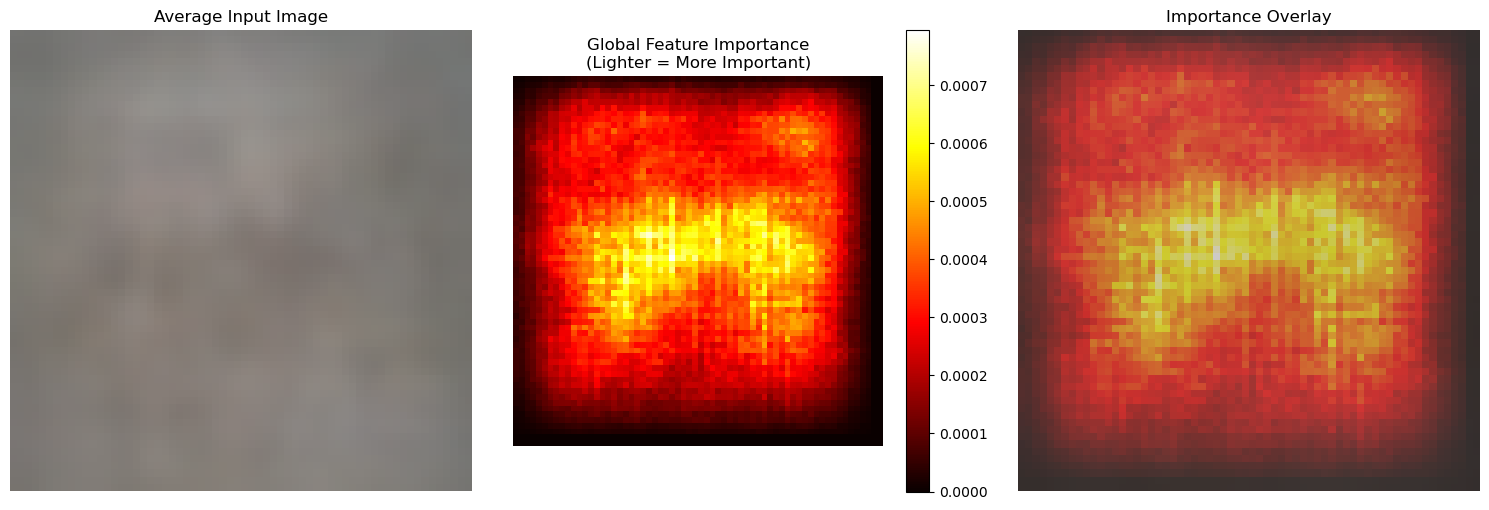

Most important pixel value: 0.0008
Average importance: 0.0003
Std importance: 0.0002

2. Class-Specific Pattern Analysis
----------------------------------------
Airplane - Samples: 37, Avg Importance: 0.0002
Dog - Samples: 63, Avg Importance: 0.0003


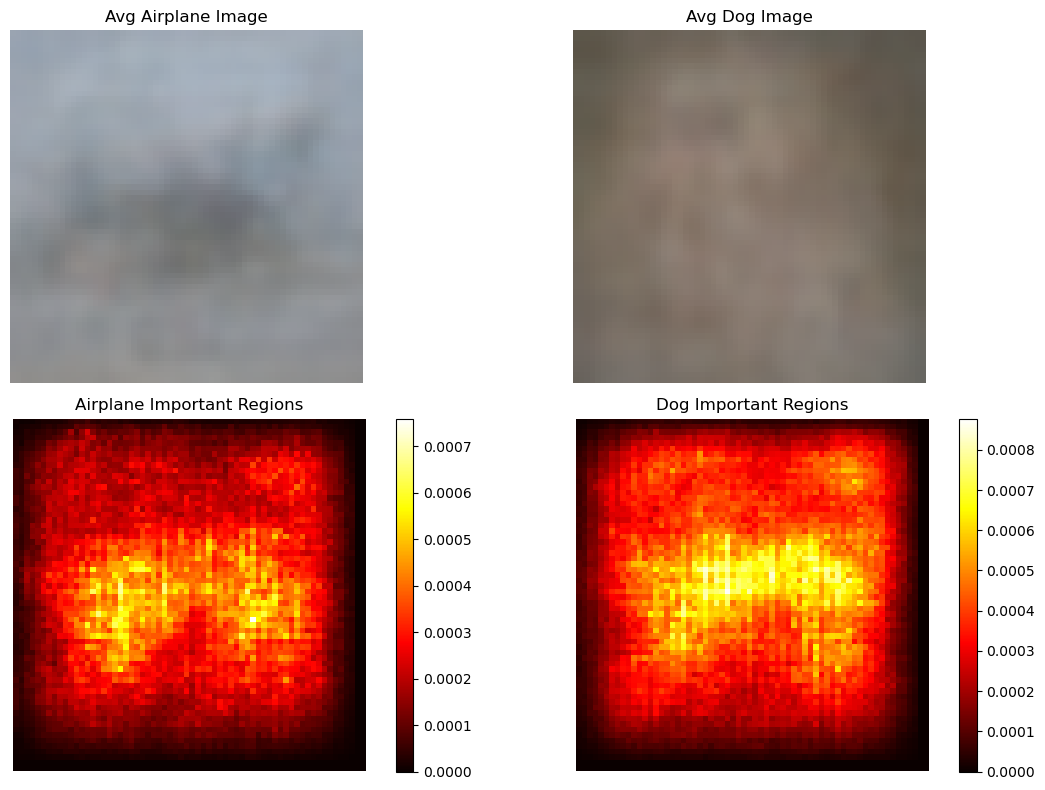


Global SHAP Analysis Complete!


In [9]:
# Assuming you have: model, x_train, x_test, y_test, CLASS_NAMES
explainer = run_global_shap_analysis(
    model=model,
    x_train=x_train,
    x_test=x_test, 
    y_test=y_test,
    class_names=CLASS_NAMES,
    background_size=50,
    analysis_size=100
)

Selecting 2 random images from each class for local explanation...
Generating local SHAP values for selected images...
SHAP values shape after fixing: (4, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Plotting local explanations...


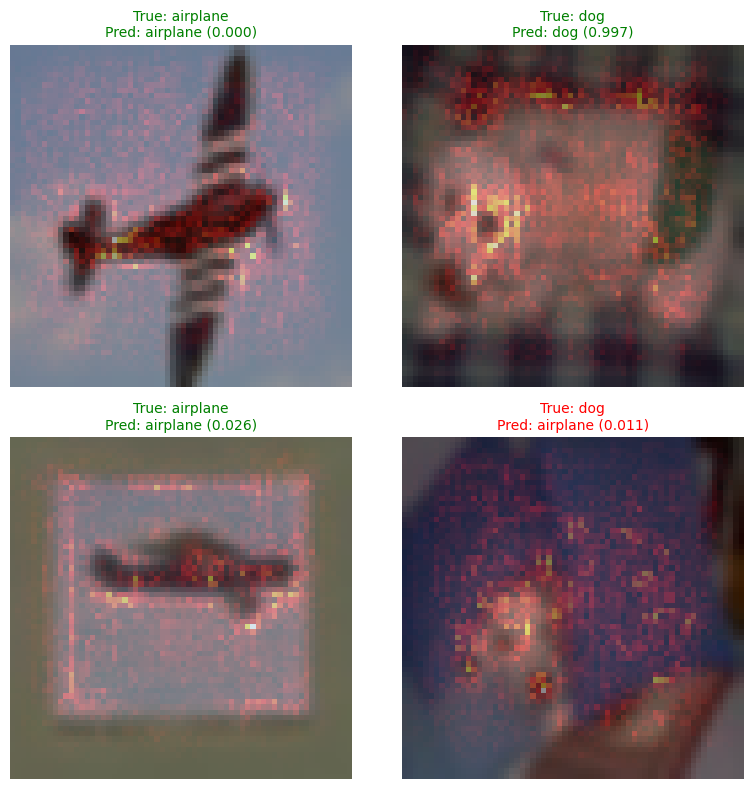

In [16]:

def show_local_shap_explanations(model, shap_explainer, x_test_data, y_test_data, class_names_list, num_images_per_class=2):
    """
    Fixed version that handles the extra dimension in SHAP values correctly
    """
    sample_images = []
    sample_labels = []
    
    # --- 1. Select random images from each class ---
    print(f"Selecting {num_images_per_class} random images from each class for local explanation...")
    for class_index, class_name in enumerate(class_names_list):
        class_indices = np.where(y_test_data == class_index)[0]
        random_indices = np.random.choice(class_indices, num_images_per_class, replace=False)
        
        sample_images.extend(x_test_data[random_indices])
        sample_labels.extend(y_test_data[random_indices])
    
    sample_images = np.array(sample_images)
    sample_labels = np.array(sample_labels)
    
    # --- 2. Generate SHAP explanations for the selected images ---
    print("Generating local SHAP values for selected images...")
    shap_values_raw = shap_explainer.shap_values(sample_images)
    
    # Fix: Handle the shape properly - SHAP returns (batch, height, width, channels, classes)
    # For binary classification, we want the first (and only) class
    if isinstance(shap_values_raw, list):
        shap_values = shap_values_raw[0]  # Take first class if list
    else:
        shap_values = shap_values_raw
    
    # Remove the extra dimension: (batch, 64, 64, 3, 1) -> (batch, 64, 64, 3)
    if shap_values.ndim == 5 and shap_values.shape[-1] == 1:
        shap_values = shap_values.squeeze(-1)
    
    print(f"SHAP values shape after fixing: {shap_values.shape}")
    
    predictions = model.predict(sample_images)
    num_classes = len(class_names_list)
    
    # Create subplot grid
    fig, axes = plt.subplots(num_images_per_class, num_classes, figsize=(4 * num_classes, 4 * num_images_per_class))
    
    # Handle axes shape
    if num_images_per_class == 1:
        axes = axes.reshape(1, -1)
    elif num_classes == 1:
        axes = axes.reshape(-1, 1)
    
    print("Plotting local explanations...")
    
    for class_idx in range(num_classes):
        for img_idx in range(num_images_per_class):
            sample_idx = class_idx * num_images_per_class + img_idx
            ax = axes[img_idx, class_idx]
            
            # Get image and normalize for display
            image = sample_images[sample_idx]
            true_label = class_names_list[int(sample_labels[sample_idx])]
            
            # Normalize image for display (0-1 range to 0-255)
            display_image = (image * 255).astype(np.uint8)
            
            # Handle predictions for binary classification
            pred_prob = predictions[sample_idx][0]
            pred_class_idx = int(pred_prob > 0.5)
            pred_label = class_names_list[pred_class_idx]
            
            # Get SHAP explanation for this sample
            shap_explanation = shap_values[sample_idx]  # Shape should now be (64, 64, 3)
            
            # Create heatmap by summing absolute values across color channels
            heatmap = np.sum(np.abs(shap_explanation), axis=-1)  # Shape: (64, 64)
            
            # Normalize heatmap for visualization
            if heatmap.max() > heatmap.min():
                heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
            
            # Plot image and overlay heatmap
            ax.imshow(display_image)
            ax.imshow(heatmap, cmap='hot', alpha=0.4)
            
            # Set title with color coding
            color = "green" if pred_label == true_label else "red"
            ax.set_title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.3f})", 
                        color=color, fontsize=10)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
show_local_shap_explanations(
    model=model,
    shap_explainer=explainer.explainer,  # Access the GradientExplainer from the wrapper class
    x_test_data=x_test,
    y_test_data=y_test,
    class_names_list=CLASS_NAMES,
    num_images_per_class=2
)